Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Visualization and Preprocessing of AirBnB Data

In [5]:
# Set-Up
import pandas as pd
import numpy as np

In [6]:
# Load Data from CSV file as pandas dataframe
df = pd.read_csv('data/airbnb_train.csv')

## Business Understanding

This dataset is provided by Kaggle and aims to predict the price of AirBnb listings in major cities in the United States. Each record is one AirBnB listing from 2018 with 29 attributes that describe the listing and what it offers to guests. A linear regression model would be a strong choice for predicting the continuous value of the listing price. The performance of this model would be measured by the root mean square error (RMSE) to determine how far predictions deviate from actual values. Using the RMSE metric is most appropriate within this context because it heavily penalizes large errors and we want to avoid significant prediction errors in listing prices.  


In addition, the rating score from the listing reviews is a potential variable of interest that can predict if past visitors would recommened certain listings. Building a classification model with this goal in mind can improve the hospitality standards of AirBnb hosts and provide a better experience for consumers. These benefits are highlighted with AirBnB's superhost program that reward hosts with the most experience and highest-rated reviews. We would use misclassification rate as our performance evaluation metric, and aim to construct a model with at least 85% accuracy. We believe models with misclassification rates greater than 15% insufficiently capture the attributes influencing highly-rated reviews and would not be useful to further our understanding of what consumers want from an AirBnb listing.

* Superhost is a program that rewards Airbnb hosts with the highest-rated reviews and most experience. Helps these hosts earn extra money, attract more guests, and access exclusive rewards.
    * Requirements: 4.8+ overall rating, 10+ stays, <1% cancellation rate, 90% response rate 

In [7]:
# Quick snapshot of Data
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


## Data Meaning Type

In [8]:
# Summary Statistics of Variables (74111x29)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

## Simple Statistics

In [9]:
df.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


## Data Quality

In [10]:
# df.isna().sum()
df_ratings = df.dropna(subset=['review_scores_rating','bathrooms','bedrooms','beds'])

Since we have a large dataset, we have decided to remove all instances with missing values for review_scores_rating (our categorial response variable), bathrooms, bedrooms, and beds to avoid any complications that may arise with imputation. We believe a dataset size of 57,129 provides sufficient information to train a well-performing model.

In [11]:
# Data Type Manipulation
# Continuous Features as Floats
continuous_features = ['log_price','latitude','longitude','review_scores_rating']
df_ratings[continuous_features] = df_ratings[continuous_features].astype(np.float64)
# Ordinal Features as Integers
ordinal_features = ['id','accommodates','bathrooms','number_of_reviews','bedrooms','beds']
df_ratings[ordinal_features] = df_ratings[ordinal_features].astype(np.int64)
# Categorical Features as Objects
categorical_features = ['property_type','room_type','bed_type','cleaning_fee','cancellation_policy','city'
                        ,'host_has_profile_pic','host_identity_verified','instant_bookable','neighbourhood','zipcode']

# cleaning_fee is a boolean
# host_has_profile_pic is a boolean
# host_identity_verified is a boolean

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [14]:
df_ratings.head(10)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1,1
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3,3
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1,3
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0,1
5,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1,Real Bed,strict,True,...,37.753164,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1,1
6,11825529,4.418841,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",3,1,Real Bed,moderate,True,...,33.980454,-118.462821,Beach Town Studio and Parking!!!11h,NaN,15,97.0,https://a0.muscache.com/im/pictures/4c920c60-4...,90292,1,1
7,13971273,4.787492,Condominium,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",2,1,Real Bed,moderate,True,...,34.046737,-118.260439,"Near LA Live, Staple's. Starbucks inside. OWN ...",Downtown,9,93.0,https://a0.muscache.com/im/pictures/61bd05d5-c...,90015,1,1
8,180792,4.787492,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Pets live ...",2,1,Real Bed,moderate,True,...,37.781128,-122.501095,Cozy Garden Studio - Private Entry,Richmond District,159,99.0,https://a0.muscache.com/im/pictures/0ed6c128-7...,94121,1,1
9,5385260,3.583519,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",2,1,Real Bed,moderate,True,...,33.992563,-117.895997,No.7 Queen Size Cozy Room 舒适大床房,NaN,2,90.0,https://a0.muscache.com/im/pictures/8d2f08ce-b...,91748,1,1
10,5578513,4.605170,Apartment,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",2,1,Real Bed,strict,True,...,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1,1


In [17]:
type(df_ratings['zipcode'])

pandas.core.series.Series

In [12]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57129 entries, 0 to 74110
Data columns (total 29 columns):
id                        57129 non-null int64
log_price                 57129 non-null float64
property_type             57129 non-null object
room_type                 57129 non-null object
amenities                 57129 non-null object
accommodates              57129 non-null int64
bathrooms                 57129 non-null int64
bed_type                  57129 non-null object
cancellation_policy       57129 non-null object
cleaning_fee              57129 non-null bool
city                      57129 non-null object
description               57129 non-null object
first_review              57128 non-null object
host_has_profile_pic      56989 non-null object
host_identity_verified    56989 non-null object
host_response_rate        47787 non-null object
host_since                56989 non-null object
instant_bookable          57129 non-null object
last_review               57128

* amenities is a list of strings
* description is a string object
* first_review is a date-time object
* host_since is a date-time object
* last_review is a date-time object
* name is a string object
* thumbnail_url is a string object

In [80]:
import theano

ModuleNotFoundError: No module named 'theano'

## Visualize Attributes

In [18]:
# Import visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

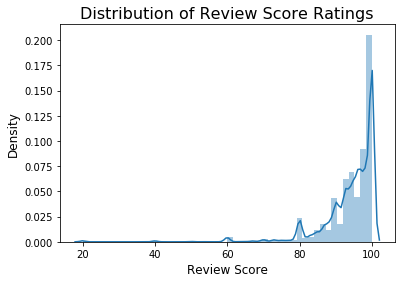

In [53]:
# Histogram for review_scores_rating, a float
sns.distplot(df_ratings['review_scores_rating'])
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Review Scores Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)

Plotting the ratings reveals a long left tail, with most ratings concentrated in the 80-100 score range. This is likely due to AirBnb's rating system, where guests rate their stay on a scale of 1 to 5 stars. Furthermore, properties that fall below a certain rating average get delisted. Combined, this likely results in an artificially biased sample where consistently strong performers are overrepresented. This is explored further in a later section.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

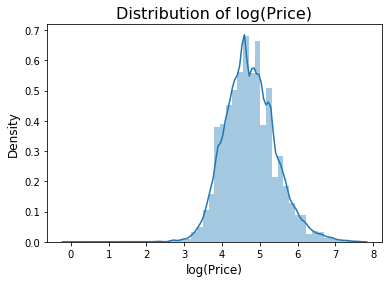

In [50]:
sns.distplot(df_ratings['log_price'])
plt.title('Distribution of log(Price)', fontsize=16)
plt.xlabel('log(Price)', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Frequency')

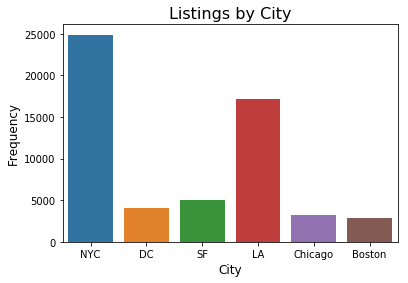

In [52]:
# Bar graph for city, a factor
sns.countplot(x="city", data=df_ratings)
plt.title('Listings by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

## Explore Joint Attributes

## Explore Attributes & Class

Text(0,0.5,'Number of Reviews')

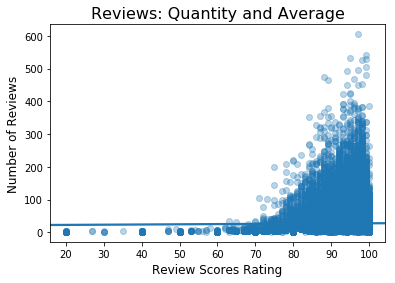

In [57]:
# Scatterplot between rating and number of reviews
sns.regplot(x='review_scores_rating', 
            y='number_of_reviews',
            data=df_ratings,
            scatter_kws={'alpha':0.3})
plt.title('Reviews: Quantity and Average', fontsize=16)
plt.xlabel('Review Scores Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

## New Features

Additional potential features could be engineered from existing attributes or derived from the original AirBnB listings.

* While log price is the original target variable, it would make sense to create a price variable that simply back-transforms the value into something more easily human-readable and business-relevant.
* A general sense for the size of the listing could be obtained from principal component analysis on accommodates, bathrooms, bedrooms, and beds. This would also likely need to account for the property and room type factors, which mention what kind and how much of the property is available to guests.
* Clustering could be performed using some combination of latitude, longitude, city, and neighborhood to get a sense for pricing trends based on physical location.
* On a related note, hosts frequently use description and name to advertise a property's proximity to popular tourist destinations, public transportation, or restaurants and nightlife. Sentiment analysis on the significance of a property's physical location could give clues about pricing.
    * For a less subjective alternative, one could bring in the latitude-longitude coordinates of known highlights in a given city and then calculate distance from the property. This could be captured in binary variables, such as whether a property is located within 0.25 miles of a public transport stop or within a city's tourist district.
* Current variables related to reviews are about quantity, scores, or dates. Sentiment analysis could be performed on select reviews (e.g., first, most recent, highest rating, lowest rating) to gain an understanding of why certain guests submitted a given score. For example, perhaps a listing's major strength is its host, and multiple reviews mention the host's hospitality and knowledge about the area. Such details are not currently captured by host-related variables in the dataset. 
    * Review text may also support a host's claims made about proximity in the description and name.

## Exceptional Work